[*********************100%***********************]  1 of 1 completed


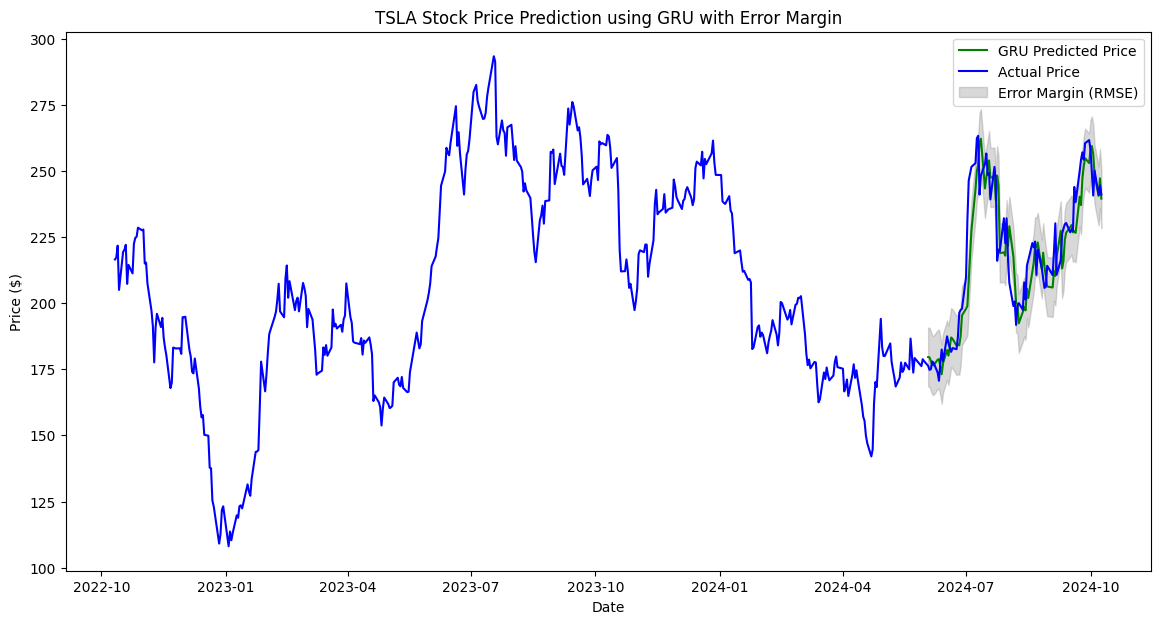

In [4]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  # train_test_split 임포트
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input  # Input 레이어 임포트
from datetime import datetime, timedelta
import find_code

# 1. 데이터 수집
start = (datetime.now() - timedelta(days=730)).strftime('%Y-%m-%d')  # 데이터 시작 날짜
end = datetime.now().strftime('%Y-%m-%d')    # 데이터 종료 날짜
company_name = input("Enter the company name (e.g., NVIDIA): ")
ticker = find_code.get_ticker(company_name)   # 회사명으로 티커 찾기       # 주식 티커
df = yf.download(ticker, start=start, end=end)  # yfinance를 사용하여 데이터 다운로드

# 2. 데이터 전처리
data = df['Close'].values.reshape(-1, 1)  # 종가를 2D 배열로 변형
scaler = MinMaxScaler(feature_range=(0, 1))  # 데이터 정규화
scaled_data = scaler.fit_transform(data)  # 데이터 정규화 수행

# 데이터셋 분할: 훈련 데이터와 테스트 데이터
train_data, test_data = train_test_split(scaled_data, test_size=0.3, shuffle=False)  # 30% 테스트 데이터

# GRU 입력 형식에 맞게 데이터 변형
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # 입력 데이터
        y.append(data[i + time_step, 0])      # 타겟 데이터
    return np.array(X), np.array(y)

# 시간 단계 설정
time_step = 60  # 60일의 데이터를 사용하여 예측
X_train, y_train = create_dataset(train_data, time_step)  # 훈련 데이터 생성
X_test, y_test = create_dataset(test_data, time_step)      # 테스트 데이터 생성

# GRU 입력 형태로 변형 (3D 배열)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# epoch = 300, dropout = 0.35
# 3. GRU 모델 구축
gru_model = Sequential()  # Sequential 모델 초기화
gru_model.add(Input(shape=(X_train.shape[1], 1)))  # Input 레이어 추가
gru_model.add(GRU(units=50, return_sequences=True))  # 첫 번째 GRU 레이어
gru_model.add(Dropout(0.35))  # 과적합 방지를 위한 Dropout
gru_model.add(GRU(units=50, return_sequences=False))  # 두 번째 GRU 레이어
gru_model.add(Dropout(0.35))  # 과적합 방지를 위한 Dropout
gru_model.add(Dense(units=1))  # 최종 출력 레이어
gru_model.compile(optimizer='adam', loss='mean_squared_error')  # 모델 컴파일

# 모델 훈련
gru_model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0)  

# 4. 예측 수행
gru_predicted_prices = gru_model.predict(X_test, verbose=0)    # GRU 예측

# 예측 결과를 원래 스케일로 변환
gru_predicted_prices = scaler.inverse_transform(gru_predicted_prices)

# 5. RMSE 계산
rmse = np.sqrt(np.mean((data[len(train_data) + time_step + 1:] - gru_predicted_prices) ** 2))

# 상한 및 하한 구간 계산 (오차 범위)
upper_bound = gru_predicted_prices + rmse
lower_bound = gru_predicted_prices - rmse

# 6. 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(df.index[len(train_data) + time_step + 1:], gru_predicted_prices, color='green', label='GRU Predicted Price')  # GRU 예측 결과
plt.plot(df.index, data, color='blue', label='Actual Price')  # 실제 가격

# 오차 범위 시각화 (상한 및 하한)
plt.fill_between(df.index[len(train_data) + time_step + 1:], lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.3, label='Error Margin (RMSE)')

plt.title(f'{ticker} Stock Price Prediction using GRU with Error Margin')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

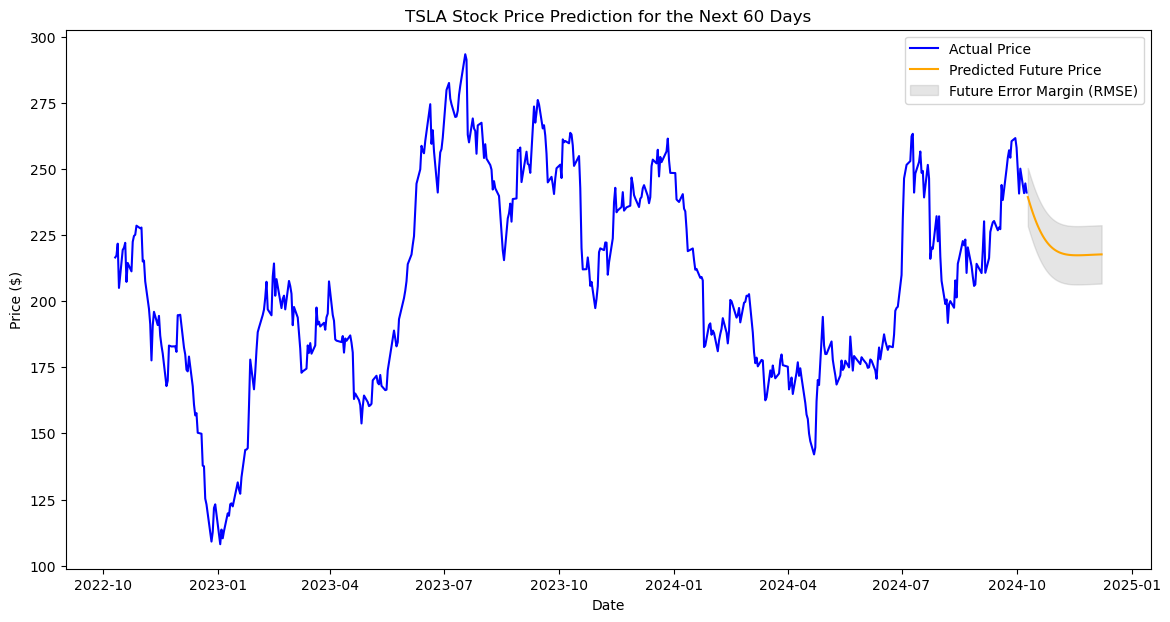

,Predicted Price,Signal
2024-10-10,239.334686,Hold
2024-10-11,237.797302,Sell
2024-10-12,236.256668,Sell
2024-10-13,234.785660,Sell
2024-10-14,233.374420,Sell
2024-10-15,232.032608,Sell
2024-10-16,230.761459,Sell
2024-10-17,229.562149,Sell
2024-10-18,228.434952,Sell
2024-10-19,227.379440,Sell


In [2]:
# 6. 미래 데이터 예측
last_data = scaled_data[-time_step:].reshape(1, time_step, 1)  # 가장 최근 60일 데이터를 준비

# 예측할 미래 기간 설정
future_days = 60
future_prices = []

# RMSE 계산
val_rmse = np.sqrt(np.mean((data[-len(gru_predicted_prices):] - gru_predicted_prices) ** 2))

# 미래 60일 예측
for _ in range(future_days):
    predicted_price = gru_model.predict(last_data, verbose=0)  # GRU 모델로 예측 수행
    future_prices.append(predicted_price[0, 0])  # 예측된 값 저장
    # 새로운 데이터를 기존의 마지막 데이터로 추가 (슬라이딩 윈도우 방식)
    last_data = np.append(last_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

# 미래 가격을 원래 스케일로 변환
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

# 7. 미래 예측 결과 시각화
future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=future_days)  # 미래 날짜 생성

plt.figure(figsize=(14, 7))
plt.plot(df.index, data, color='blue', label='Actual Price')  # 실제 데이터 시각화
plt.plot(future_dates, future_prices, color='orange', label='Predicted Future Price')  # 예측 데이터 시각화

# 미래 예측의 상한선과 하한선 시각화
future_upper_bound = future_prices + val_rmse
future_lower_bound = future_prices - val_rmse

plt.fill_between(future_dates, future_lower_bound.flatten(), future_upper_bound.flatten(), color='gray', alpha=0.2, label='Future Error Margin (RMSE)')

plt.title(f'{ticker} Stock Price Prediction for the Next {future_days} Days')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# 8. 예상 주가 출력 및 Buy/Sell 신호 생성
predicted_prices_df = pd.DataFrame(future_prices, index=future_dates, columns=['Predicted Price'])

# Buy/Sell 신호 생성: 현재 예상 주가가 전날보다 높으면 Buy, 낮으면 Sell
buy_sell_signals = []
for i in range(1, len(predicted_prices_df)):
    if predicted_prices_df['Predicted Price'].iloc[i] > predicted_prices_df['Predicted Price'].iloc[i - 1]:
        buy_sell_signals.append('Buy')
    else:
        buy_sell_signals.append('Sell')

# 첫날은 비교할 이전 가격이 없으므로 신호 없음
buy_sell_signals.insert(0, 'Hold')

# 예상 주가와 함께 Buy/Sell 신호 추가
predicted_prices_df['Signal'] = buy_sell_signals

# 예상 주가와 Buy/Sell 신호 출력
predicted_prices_df